Section 1: Generative networks 1: variational autoencoders and MNIST characters (20 mins)
Video 1: Normal autoencoders
Video 2: Applying autoencoders
Video 3: Adding the "variational part" of a VAE
Video 4: Practical use of your autoencoder: noise removal


In [ ]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("datasets/MNIST_data/", one_hot=True)

# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

# Building the encoder
def encoder(x):
    layer_1 = tf.layers.dense(inputs=x, 
                              units=num_hidden_1, 
                              activation=tf.nn.sigmoid)
    layer_2 = tf.layers.dense(inputs=layer_1, 
                              units=num_hidden_2, 
                              activation=tf.nn.sigmoid)
    return layer_2


# Building the decoder
def decoder(x):
    layer_1 = tf.layers.dense(inputs=x, 
                              units=num_hidden_1, 
                              activation=tf.nn.sigmoid)
    layer_2 = tf.layers.dense(inputs=layer_1, 
                              units=num_input, 
                              activation=tf.nn.sigmoid)
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        print('Step %i: Minibatch Loss: %f' % (i, l))



In [ ]:

# Encode and decode images from test set and visualize their reconstruction.
batch_x, _ = mnist.test.next_batch(n)
# Encode and decode the digit image
g = sess.run(decoder_op, feed_dict={X: batch_x})
for index in range(n):

    plt.imshow(np.reshape(batch_x[index,:],(28,28)))
    plt.show()
    plt.imshow(np.reshape(g[index,:],(28,28)))
    plt.show()

## Why use autoencoder

There are some uses for autoencoders. One of them is the removal of noise in images. If you have an image with noise as input and pass it through an autoencoder your decoded images is noise-free!

It can also serve as a compression mechanism. You compress input images into a lower dimensional space, and can use this lower dimensional space as input for other algorithms. This way the autoencoder can serve as a first step in an unsupervised algorithm. Note that during the compressing and expanding we never used the labels, the neural network learned everything himself. This sparse-autoencoder is useful as pre-training, even for normal classification tasks!


## Video: variational autoencoder

There is a really good blog about variational autoencoders. Please [take a look at it](http://kvfrans.com/variational-autoencoders-explained/). 
You can even use an autoencoder to generate new images. By feeding values in the middle of your network your network will generate a new image. However: we don't know what range of values we can feed, and what this will result in. 

Although you can already do that right now, you get the best results using a so-called variational autoencoder. In that case we add an additional constraint to our neural network: the center layer has to follow a so-called "unit gaussian distribution". After we did this we can simply sample values from the same distribution, and we know this will result in a good looking image!


Great explanation of Kullback Leibler divergence using space worms analogy: https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline


from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28


class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

    
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtina a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))
            
    print('Done!')
    return model



model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)



# Test the trained model: reconstruction
batch = mnist.test.next_batch(100)
x_reconstructed = model.reconstructor(batch[0])

n = np.sqrt(model.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')



# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')




tf.reset_default_graph()
# Train the model with 2d latent space
model_2d = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=50, n_z=2)



# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.colorbar()
plt.grid()


# En dan nu Rolands uitgeklede versie



In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline


from tensorflow.examples.tutorials.mnist import input_data

tf.reset_default_graph()
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28

batch_size = 100
n_z = 10

x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

# Encode
# x -> z_mean, z_sigma -> z
f1 = fc(x, 512, activation_fn=tf.nn.relu)
f2 = fc(f1, 384, activation_fn=tf.nn.relu)
f3 = fc(f2, 256, activation_fn=tf.nn.relu)

# Z part
z_mu = fc(f3, n_z, activation_fn=None)
z_log_sigma_sq = fc(f3, n_z, activation_fn=None)
eps = tf.random_normal(shape=tf.shape(z_log_sigma_sq),mean=0, stddev=1, dtype=tf.float32)
z = z_mu + tf.sqrt(tf.exp(z_log_sigma_sq)) * eps

# Decode
# z -> x_hat
g1 = fc(z, 256, activation_fn=tf.nn.relu)
g2 = fc(g1, 384, activation_fn=tf.nn.relu)
g3 = fc(g2, 512, activation_fn=tf.nn.relu)
x_hat = fc(g3, input_dim, activation_fn=tf.sigmoid)

# Loss
# Reconstruction loss
# Minimize the cross-entropy loss
# H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
epsilon = 1e-10
recon_loss = -tf.reduce_sum(x * tf.log(epsilon+x_hat) + (1-x) * tf.log(epsilon+1-x_hat), axis=1)
recon_loss = tf.reduce_mean(recon_loss)

# Latent loss
# Kullback Leibler divergence: measure the difference between two distributions
# Here we measure the divergence between the latent distribution and N(0, 1)
latent_loss = -0.5 * tf.reduce_sum(
    1 + z_log_sigma_sq - tf.square(z_mu) - tf.exp(z_log_sigma_sq), axis=1)
latent_loss = tf.reduce_mean(latent_loss)

total_loss = tf.reduce_mean(recon_loss + latent_loss)
train_op = tf.train.AdamOptimizer().minimize(total_loss)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [22]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

num_epoch = 30
for epoch in range(num_epoch):
    for iter in range(num_sample // batch_size):

        batch = mnist.train.next_batch(batch_size)
        _, loss, res_recon_loss, res_latent_loss = sess.run([train_op, total_loss, recon_loss, latent_loss],
                                                     feed_dict={x: batch[0]})
    print("Hoi")
    print("Loss: %f recon loss: %f latent loss: %f " % (loss, res_recon_loss, res_latent_loss))

assert res_recon_loss < 100
assert loss < 105

Hoi
Loss: 130.958130 recon loss: 115.211502 latent loss: 15.746626 
Hoi
Loss: 109.820793 recon loss: 92.993317 latent loss: 16.827478 
Hoi
Loss: 113.078346 recon loss: 95.540901 latent loss: 17.537443 
Hoi
Loss: 105.501022 recon loss: 87.794144 latent loss: 17.706875 
Hoi
Loss: 106.400635 recon loss: 88.337326 latent loss: 18.063305 
Hoi
Loss: 112.211807 recon loss: 94.106094 latent loss: 18.105711 
Hoi
Loss: 109.252457 recon loss: 90.902122 latent loss: 18.350332 
Hoi
Loss: 105.805611 recon loss: 87.757591 latent loss: 18.048018 
Hoi
Loss: 103.462051 recon loss: 85.379372 latent loss: 18.082684 
Hoi
Loss: 104.933304 recon loss: 86.320137 latent loss: 18.613165 
Hoi
Loss: 105.007607 recon loss: 86.857224 latent loss: 18.150381 
Hoi
Loss: 100.365814 recon loss: 82.278084 latent loss: 18.087730 
Hoi
Loss: 105.464310 recon loss: 86.950226 latent loss: 18.514082 
Hoi
Loss: 103.402557 recon loss: 85.162003 latent loss: 18.240555 
Hoi
Loss: 101.988121 recon loss: 83.239571 latent loss: 18.74

AssertionError: 

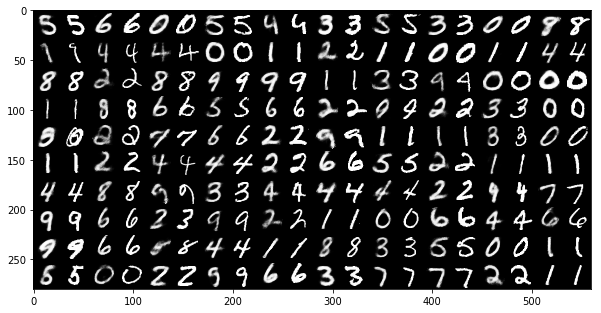

In [16]:
x_reconstructed = sess.run(x_hat, feed_dict={x: batch[0]})


n = np.sqrt(100).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        blaatje = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = blaatje

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')


In [ ]:
#     # x -> x_hat
#     def reconstructor(self, x):
#         x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
#         return x_hat

#     # z -> x
#     def generator(self, z):
#         x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
#         return x_hat
    
#     # x -> z
#     def transformer(self, x):
#         z = self.sess.run(self.z, feed_dict={self.x: x})
#         return z

    
# def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
#     model = VariantionalAutoencoder(learning_rate=learning_rate,
#                                     batch_size=batch_size, n_z=n_z)


#             # Execute the forward and the backward pass and report computed losses
#             loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
#         if epoch % 5 == 0:
#             print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
#                 epoch, loss, recon_loss, latent_loss))
            
#     print('Done!')
#     return model



# model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)



# Test the trained model: reconstruction
batch = mnist.test.next_batch(100)
x_reconstructed = model.reconstructor(batch[0])

n = np.sqrt(model.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')



# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')




tf.reset_default_graph()
# Train the model with 2d latent space
model_2d = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=50, n_z=2)



# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.colorbar()
plt.grid()

## Eind Rolands versie

In [ ]:
vals = [-1.5, -1.0, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 1.5]
for x in vals:
    for y in vals:
        a = sess.run(decoder_op, feed_dict={z: [[x,y]]})
        a = np.reshape(a[0],(28,28))
        plt.imshow(a)
        plt.show()


Section 2: Generative networks 2: generative adversarial networks (20 mins)
Video 1: Building the "adversarial detector" 
Video 2: Generating new images with an adversarial generator
Video 3: Training both networks: a min-max game
Video 4: Improving your GAN: Wasserstein GANs 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

data = input_data.read_data_sets("datasets/MNIST_data")
batch_size = 64

'''
  Helper functions for network
'''
def binarize(img):
    return (np.random.uniform(size=img.shape) < img).astype(np.float32)
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1))
def get_bias(shape):
    return tf.Variable(tf.constant(shape=shape, value=0.1))

def generator(g_input):
    with tf.name_scope('G'):
        l1_size, l2_size = 1200, 1200
        g_w1 = get_weights([28*28, l1_size])
        g_b1 = get_bias([l1_size])
        g_w2 = get_weights([l1_size, l2_size])
        g_b2 = get_bias([l2_size])
        g_w3 = get_weights([l2_size, 28*28])
        g_b3 = get_bias([28*28])

        l1 = tf.nn.relu(tf.add(tf.matmul(X, g_w1), g_b1))
        l2 = tf.nn.relu(tf.add(tf.matmul(l1, g_w2), g_b2))
        logits = tf.sigmoid(tf.add(tf.matmul(l2, g_w3), g_b3))
        return logits
    
class Discriminator():
    def __init__(self):
        with tf.name_scope('D'):
            d_l1_size, d_l2_size = 500, 100
            self.d_w1 = get_weights([28*28, d_l1_size])
            self.d_b1 = get_bias([d_l1_size])
            self.d_w2 = get_weights([d_l1_size, d_l2_size])
            self.d_b2 = get_bias([d_l2_size])
            self.d_w3 = get_weights([d_l2_size, 1])
            self.d_b3 = get_bias([1])

    def network(self, d_input):
        d_l1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(d_input, self.d_w1), self.d_b1)), 0.5)
        d_l2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(d_l1, self.d_w2), self.d_b2)), 0.5)
        pred = tf.sigmoid(tf.add(tf.matmul(d_l2, self.d_w3), self.d_b3))
        return pred

X = tf.placeholder(shape=[None, 28*28], dtype=tf.float32)
Z = tf.placeholder(shape=[None, 28*28], dtype=tf.float32)

g_z = generator(Z)
decoder = Discriminator()
d_x = decoder.network(X)
d_z = decoder.network(g_z)

g_batch = tf.Variable(0)
d_batch = tf.Variable(0)

g_loss = - tf.reduce_mean(tf.reduce_sum(tf.log(d_z), reduction_indices=[1]))
g_learning_rate = tf.train.exponential_decay(0.01, g_batch, 100, 0.95, staircase=True)
g_optimizer = tf.train.MomentumOptimizer(g_learning_rate, 0.9).minimize(g_loss)

d_loss = - tf.reduce_mean(tf.reduce_sum(tf.log(d_x) + tf.log(1-d_z), reduction_indices=[1]))
d_learning_rate = tf.train.exponential_decay(0.01, g_batch, 100, 0.95, staircase=True)
d_optimizer = tf.train.MomentumOptimizer(d_learning_rate, 0.9).minimize(d_loss)

epochs = 1000
k = 5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        for j in range(k):
            # NOTE using an arbitary distribution as noise
            batch_z = np.random.normal(0, 0.1, (batch_size,28*28))
            batch_x = binarize(data.train.next_batch(batch_size)[0])
            _, d_l = sess.run([d_optimizer, d_loss], feed_dict={X:batch_x, Z:batch_z})
            
        batch_z = np.random.normal(0, 0.1, batch_size*28*28).reshape((batch_size, 28*28))
        batch_x = data.train.next_batch(batch_size)[0]
        _t, g_l = sess.run([g_optimizer, g_loss], feed_dict={X:batch_x, Z:batch_z})
        if i%100 ==0:

            results = sess.run(g_z, feed_dict={X:batch_x, Z:batch_z})
            plt.imshow(np.reshape(results[0],(28,28)))
            plt.show()
            print("generator_loss:%f, decoder_loss:%f"%(g_l, d_l))
 



Section 3: Deep q-learning with the OpenAI Gym (25 mins)
Video 1:Exploring input and output of different games
Video 2: Random search. Solving your first problem, and joining the leaderboard
Video 3: Reinforcement learning explained: approximating the value function
Video 4: Remembering your actions: adding a replay memory
Video 5: Introduction to the Atari environment


## Video 1: Exploring input and output of different environments
To use the OpenAI gym you have to install the Gym environment. 

Use this URL: https://gym.openai.com

Environments can be found here: https://gym.openai.com/envs/

Let's start with importing the OpenAI gym

In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

import gym

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

# Create the environment and display the initial state
env = gym.make('CartPole-v0')
observation = env.reset()
firstframe = env.render(mode = 'rgb_array')
fig,ax = plt.subplots()
im = ax.imshow(firstframe) 




something about pressing random buttons.

In [ ]:


frames = []
observation, reward, done, info = env.step(action)
frame = env.render(mode = 'rgb_array')
im.set_data(frame)
frames.append(frame)
if done:
    env.reset()


In [ ]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

display_frames_as_gif(frames, filename_gif="manualplay.gif")


In [ ]:
%matplotlib notebook
from time import gmtime, strftime
import threading
import time

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display
import tensorflow as tf
import gym
from gym import wrappers
import random

from matplotlib import animation
from JSAnimation.IPython_display import display_animation

env = gym.make('CartPole-v0')
observation = env.reset()


## Value approximation

The goal of deep q learning is to estimate the reward you can get after a longer time for each action. 

Imagine you have this stick: 
-- image of a stick that is falling to the right

If you push the cart to the left, the stick will probably fall within a few frames. You would only get a few points. 

However, if you push the cart to the right, the stick will start to stand back up, and you will get a lot of points!

For each action we approximate the "value" that that action will bring. To do that we use an equation called the [Bellman Equation](https://en.wikipedia.org/wiki/Bellman_equation). In a nutshell this equation says you have to estimate the reward as: 
- The reward you get immediately
- A discount reward for every next timestep

It's like making an investment: sometimes an action that does not immediately give you a good reward will give you a reward later. 

For balancing a cartpole this is important, as for every action you get a reward, so any action except a dying action gives you a reward...

Although we could manually make a reward function (like: a higher reward is our pole has a low angle and no speed), let's keep using this reward function. 




### Environments that are difficult
Note that not every environment is now solvable with this algorithm. The cart that goes up the hill is kind of impossible with the current algorithm: you only get a reward if you reach the top...



## Atari games, and what to look for
There is also a huge list of Atari games you can try to solve. As training such a network takes a very long time (like: 24 hours) I won't give you the direct code for it in this video. I will give a lot of tips that can help you bring up this code. On my blog pinchofintelligence.com I did make a Jupyter notebook which gave me a trained network for the Atari set. 




Section 4: Timeseries and recurrent neural networks (20 mins)
Video 1: Dataset: predict stock price - simple RNN
Video 2: Unreasonable effectiveness of LSTMs
Video 3: Comparing LSTM to GRU cell


REMOVE THiS: Video 4: Recurrent neural networks in images and text


https://www.kaggle.com/camnugent/sandp500

Recurrent neural network: output is a combination of input AND previous state. 

Normal neural network only takes input, can't be used to do things like: predict something after a sentence, or predict the next frame in a video. 




Section 5: Learning from only one sample: simple siamese neural networks (15 mins)
Video 1: Discussion on methods with one sample (intro dataset)
Video 2: Defining a good loss function
Video 3: Training and testing your network. 

https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

https://sorenbouma.github.io/blog/oneshot/


In [ ]:
import sys
import numpy as np
from scipy.misc import imread
#import dill as pickle
import os
import matplotlib.pyplot as plt
import argparse

data_path = "datasets/omniglot/"
basepath = os.path.join(data_path,'images_background')
valpath = os.path.join(data_path,'images_evaluation')
lang_dict = {}

def loadimgs(path,n=0):
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    #we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):

        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        #every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            if not os.path.isdir(letter_path):
                continue

            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,lang_dict

X,y,c=loadimgs(basepath)


# with open("train.pickle", "wb") as f:
#     pickle.dump((X,c),f)


X,y,c=loadimgs(valpath)
# with open("val.pickle", "wb") as f:
#     pickle.dump((X,c),f)

## Section idea: advanced classification problems 1: regularisation stuff
## Section idea: advanced classification problems 2: the siamese stuff
## Section idea: something with those layers that pass gradients faster!
